## CNN Classification on CIFAR-10

This notebook implements a complete Convolutional Neural Network (CNN) for classifying images from the CIFAR-10 dataset.  
The model takes 32x32 RGB images (center-cropped to 24x24) and processes them through a stack of convolutional, activation, and pooling layers before producing class probabilities.

### Architecture

- **Input:** 24x24x3

**Feature Extraction**
- **Conv1 (3x3, ReLU):** 24x24x64  
- **MaxPool (3x3, s=2):** 12x12x64
- **Conv2 (3x3, ReLU):** 12x12x32  
- **MaxPool (3x3, s=2):** 6x6x32
- **Conv3 (3x3, ReLU):** 6x6x20  
- **MaxPool (3x3, s=2):** 3x3x20

**Classifier**
- **Flatten:** 180 features  
- **FC:** 180 → 10  
- **Softmax:** class probabilities

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import cv2
import re

### Functions Summary

- **load_pickle(file)**  
  Loads and returns a dictionary from a CIFAR-10 batch file using Python’s pickle module.

- **normalize_img(img)**  
  Computes the mean and standard deviation of a 24x24x3 image and returns a normalized version.

- **load_cnn_weights(filename)**  
  Parses a weight file, extracts tensors, reshapes them into their correct shapes, and returns all CNN parameters.

- **conv2d_relu(img, kernel, bias)**  
  Performs a 3x3 convolution (SAME padding), adds bias, applies ReLU, and returns output feature maps.
  
- **maxpool2d(img, pool_size=3, stride=2)**  
  Applies max pooling using a 3x3 window and stride 2.

- **flatten(img)**  
  Flattens a 3D feature map into a 1D vector.

- **dense_layer(input_vector, weight, bias)**  
  Computes a fully connected layer: \( W^T x + b \), returning logits.

- **softmax_activation(logits)**  
  Applies the softmax function to convert logits into class probabilities.

In [3]:
def load_pickle(file):
    """Load a CIFAR-10 batch file using pickle."""
    import pickle
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def normalize_img(img):
    """Normalize a 24x24x3 image using mean and standard deviation."""
    mean = 0.0
    N = 24 * 24 * 3
    
    for i in range(24):
        for j in range(24):
            for c in range(3):
                mean += float(img[i][j][c])
    mean /= N

    std_dev = 0.0
    for i in range(24):
        for j in range(24):
            for c in range(3):
                std_dev += (float(img[i][j][c]) - mean)**2
    std_dev = np.sqrt(std_dev / N)

    return (img - mean) / max(std_dev, 1 / np.sqrt(N))


def load_cnn_weights(filename):
    """Parse CNN weight tensors from the text file and reshape them."""
    with open(filename, 'r') as f:
        content = f.read()

    tensors = {}
    sections = content.split('tensor_name:')[1:]

    for section in sections:
        lines = section.strip().split('\n', 1)
        tensor_name = lines[0].strip()

        if len(lines) > 1:
            array_text = lines[1]
            start_idx = array_text.find('[')
            end_idx = array_text.rfind(']')
            if start_idx != -1 and end_idx != -1:
                numbers_text = array_text[start_idx+1:end_idx]
                numbers = re.findall(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', numbers_text)
                tensor_data = np.array([float(x) for x in numbers], dtype=np.float32)
                tensors[tensor_name] = tensor_data

    tensors['conv1/weights'] = tensors['conv1/weights'].reshape(3, 3, 3, 64)
    tensors['conv2/weights'] = tensors['conv2/weights'].reshape(3, 3, 64, 32)
    tensors['conv3/weights'] = tensors['conv3/weights'].reshape(3, 3, 32, 20)
    tensors['local3/weights'] = tensors['local3/weights'].reshape(180, 10)

    return tensors


def conv2d_relu(img, kernel, bias):
    """
    Apply a 3x3 convolution with SAME padding followed by ReLU.
    """
    H, W, C_in = img.shape
    kernel_size, _, _, C_out = kernel.shape
    pad_size = kernel_size // 2

    padded_img = np.pad(img,
                        pad_width=((pad_size, pad_size),
                                   (pad_size, pad_size),
                                   (0, 0)),
                        mode='constant',
                        constant_values=0)

    output = np.zeros((H, W, C_out), dtype=np.float32)

    for f in range(C_out):
        for i in range(H):
            for j in range(W):
                region = padded_img[i:i+kernel_size, j:j+kernel_size, :]
                output[i, j, f] = np.maximum(0, np.sum(region * kernel[:, :, :, f]) + bias[f])

    return output


def maxpool2d(img, pool_size=3, stride=2):
    """
    Apply 2D max pooling with a given window and stride.
    """
    H, W, C = img.shape
    out_h = int(np.ceil((H - pool_size) / stride)) + 1
    out_w = int(np.ceil((W - pool_size) / stride)) + 1

    output = np.zeros((out_h, out_w, C), dtype=np.float32)
    H, W, C = img.shape

    out_h = int(np.ceil((H - pool_size) / stride)) + 1
    out_w = int(np.ceil((W - pool_size) / stride)) + 1

    out = np.zeros((out_h, out_w, C), dtype=np.float32)

    for i in range(out_h):
        h0 = i * stride
        h1 = min(h0 + pool_size, H)
        for j in range(out_w):
            w0 = j * stride
            w1 = min(w0 + pool_size, W)
            region = img[h0:h1, w0:w1, :]
            out[i, j] = region.max(axis=(0, 1))

    return out


def flatten(img):
    """Flatten a 3D array (HxWxC) into a 1D vector."""
    return img.flatten().astype(np.float32)


def dense_layer(x, weight, bias):
    """Fully connected layer: Wᵀx + b."""
    return np.dot(x, weight) + bias


def softmax_activation(logits):
    """Compute softmax probabilities."""
    shifted = logits - np.max(logits)
    exp_vals = np.exp(shifted)
    return exp_vals / np.sum(exp_vals)

Load files for test data and tensor weights

In [4]:
test_data = load_pickle("../dataset/cifar-10-batches-py/test_batch")
tensors = load_cnn_weights('../dataset/CNN_coeff_3x3.txt')

Visualize 9 images from data

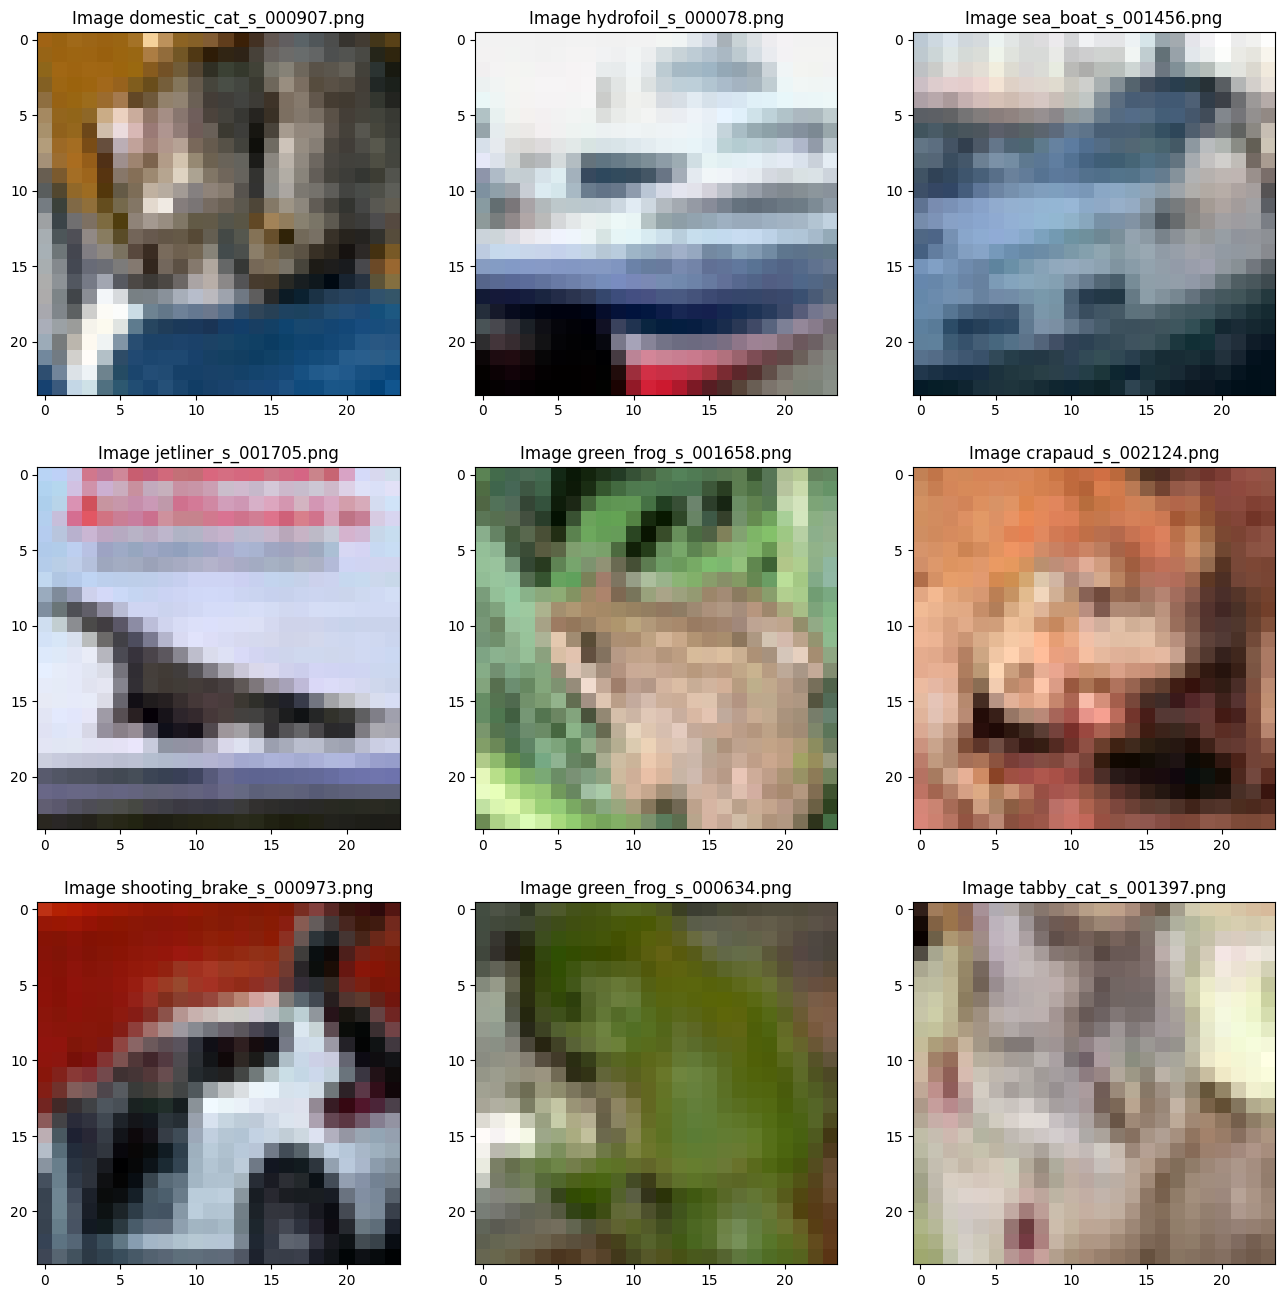

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        img = test_data[b'data'][idx].reshape(3,32,32).transpose(1,2,0)
        img = img[4:28, 4:28, :]
        img = normalize_img(img)
        axes[i, j].imshow((img - img.min()) / (img.max() - img.min()))
        axes[i, j].axis('on')
        axes[i, j].set_title(f"Image {test_data[b'filenames'][idx].decode('utf-8')}")
plt.show()

CNN Accuracy Testing

In [6]:
# CIFAR-10 class names
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

N = 100
accuracy_count = 0
class_correct = np.zeros(10, dtype=int)
class_total = np.zeros(10, dtype=int)

print(f"\nTesting CNN on {N} images...\n")

start_time = time.time()

for i in range(N):

    # Preprocess image
    img = test_data[b'data'][i].reshape(3, 32, 32).transpose(1, 2, 0)
    img = img[4:28, 4:28, :]
    img = normalize_img(img)

    # Forward pass
    o1 = conv2d_relu(img, tensors['conv1/weights'], tensors['conv1/biases'])
    p1 = maxpool2d(o1)

    o2 = conv2d_relu(p1, tensors['conv2/weights'], tensors['conv2/biases'])
    p2 = maxpool2d(o2)

    o3 = conv2d_relu(p2, tensors['conv3/weights'], tensors['conv3/biases'])
    p3 = maxpool2d(o3)

    vec = flatten(p3)
    logits = dense_layer(vec, tensors['local3/weights'], tensors['local3/biases'])
    probs = softmax_activation(logits)

    predicted_label = np.argmax(probs)
    true_label = test_data[b'labels'][i]

    # Update accuracy
    if predicted_label == true_label:
        accuracy_count += 1
        class_correct[true_label] += 1
    class_total[true_label] += 1

    if (i + 1) % 100 == 0:
        elapsed = time.time() - start_time
        avg = elapsed / (i + 1)
        eta = avg * (N - i - 1)
        print(f"[{i+1:5d}/{N}] Accuracy: {accuracy_count/(i+1)*100:.2f}% | "
              f"Time: {elapsed:.1f}s | ETA: {eta:.1f}s")

elapsed_total = time.time() - start_time

print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"Total images tested: {N}")
print(f"Correct predictions: {accuracy_count}")
print(f"Overall Accuracy: {accuracy_count/N*100:.2f}%")
print(f"Total time: {elapsed_total:.2f}s")
print(f"Avg time per image: {elapsed_total/N*1000:.2f} ms")

print(f"\n{'='*60}")
print("Per-Class Accuracy")
print(f"{'='*60}")

for i in range(10):
    acc = class_correct[i] / class_total[i] * 100
    bar = "█" * int(acc / 2)
    print(f"{i}. {cifar10_classes[i]:12s}: {class_correct[i]:4d}/{class_total[i]:4d} "
          f"= {acc:6.2f}% {bar}")



Testing CNN on 100 images...

[  100/100] Accuracy: 76.00% | Time: 51.6s | ETA: 0.0s

FINAL RESULTS
Total images tested: 100
Correct predictions: 76
Overall Accuracy: 76.00%
Total time: 51.60s
Avg time per image: 515.99 ms

Per-Class Accuracy
0. airplane    :    8/  10 =  80.00% ████████████████████████████████████████
1. automobile  :    6/   6 = 100.00% ██████████████████████████████████████████████████
2. bird        :    5/   8 =  62.50% ███████████████████████████████
3. cat         :    7/  10 =  70.00% ███████████████████████████████████
4. deer        :    3/   7 =  42.86% █████████████████████
5. dog         :    6/   8 =  75.00% █████████████████████████████████████
6. frog        :   15/  16 =  93.75% ██████████████████████████████████████████████
7. horse       :    8/  11 =  72.73% ████████████████████████████████████
8. ship        :    9/  13 =  69.23% ██████████████████████████████████
9. truck       :    9/  11 =  81.82% ████████████████████████████████████████



✓ Results visualization saved as 'cnn_accuracy_results.png'


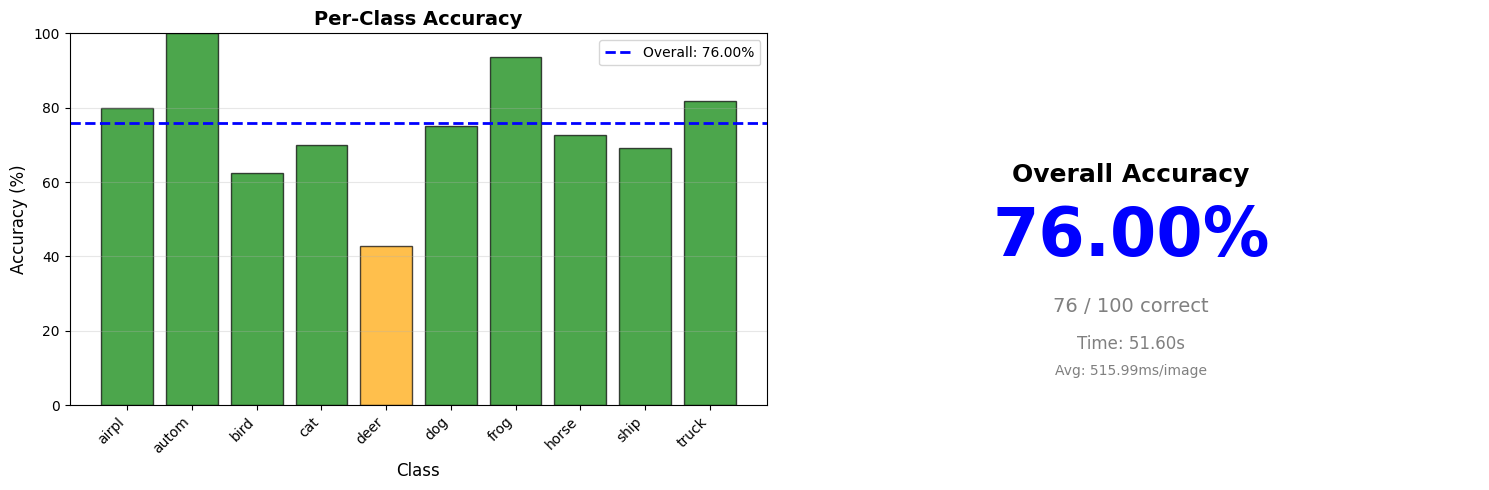

In [7]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Per-class accuracy bar chart
class_accuracies = [class_correct[i] / class_total[i] * 100 for i in range(10)]
colors = ['green' if acc >= 60 else 'orange' if acc >= 40 else 'red' for acc in class_accuracies]

axes[0].bar(range(10), class_accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhline(y=accuracy_count/N*100, color='blue', linestyle='--', linewidth=2, label=f'Overall: {accuracy_count/N*100:.2f}%')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels([c[:5] for c in cifar10_classes], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].legend()
axes[0].set_ylim([0, 100])

# Confusion matrix visualization (simplified)
axes[1].text(0.5, 0.6, f'Overall Accuracy', fontsize=18, ha='center', fontweight='bold')
axes[1].text(0.5, 0.4, f'{accuracy_count/N*100:.2f}%', fontsize=48, ha='center', color='blue', fontweight='bold')
axes[1].text(0.5, 0.25, f'{accuracy_count} / {N} correct', fontsize=14, ha='center', color='gray')
axes[1].text(0.5, 0.15, f'Time: {elapsed_total:.2f}s', fontsize=12, ha='center', color='gray')
axes[1].text(0.5, 0.08, f'Avg: {elapsed_total/N*1000:.2f}ms/image', fontsize=10, ha='center', color='gray')
axes[1].axis('off')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('cnn_accuracy_results.png', dpi=150, bbox_inches='tight')
print("\n✓ Results visualization saved as 'cnn_accuracy_results.png'")
plt.show()

Collect Predictions & Define Evaluation Functions

In [8]:
def get_predictions(n_samples=100):
    """Run inference to collect lists of true and predicted labels."""
    y_true = []
    y_pred = []
    
    print(f"Collecting predictions for {n_samples} images...")
    
    for i in range(n_samples):
        # Load and Preprocess
        img = test_data[b'data'][i].reshape(3, 32, 32).transpose(1, 2, 0)
        img = img[4:28, 4:28, :] # Center crop
        img = normalize_img(img)

        # Forward Pass
        o1 = conv2d_relu(img, tensors['conv1/weights'], tensors['conv1/biases'])
        p1 = maxpool2d(o1)
        o2 = conv2d_relu(p1, tensors['conv2/weights'], tensors['conv2/biases'])
        p2 = maxpool2d(o2)
        o3 = conv2d_relu(p2, tensors['conv3/weights'], tensors['conv3/biases'])
        p3 = maxpool2d(o3)
        
        vec = flatten(p3)
        logits = dense_layer(vec, tensors['local3/weights'], tensors['local3/biases'])
        probs = softmax_activation(logits)
        
        # Store Results
        y_pred.append(np.argmax(probs))
        y_true.append(test_data[b'labels'][i])
        
    return np.array(y_true), np.array(y_pred)

def calculate_confusion_matrix(y_true, y_pred, num_classes=10):
    """
    Compute Confusion Matrix C where C[i, j] is the number of observations
    known to be in group i and predicted to be in group j.
    """
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

def calculate_metrics(cm):
    """
    Calculate Precision, Recall, and F1 Score for each class based on CM.
    """
    metrics = {}
    num_classes = cm.shape[0]
    
    # Arrays to store per-class metrics
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(num_classes):
        # TP: Diagonal element
        TP = cm[i, i]
        
        # FP: Sum of column i minus TP
        FP = np.sum(cm[:, i]) - TP
        
        # FN: Sum of row i minus TP
        FN = np.sum(cm[i, :]) - TP
        
        # TN: Total sum minus row i and column i (Rest of the matrix)
        TN = np.sum(cm) - (TP + FP + FN)
        
        # Calculate Metrics (handle division by zero)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    return precisions, recalls, f1_scores

Execute and Visualize Results

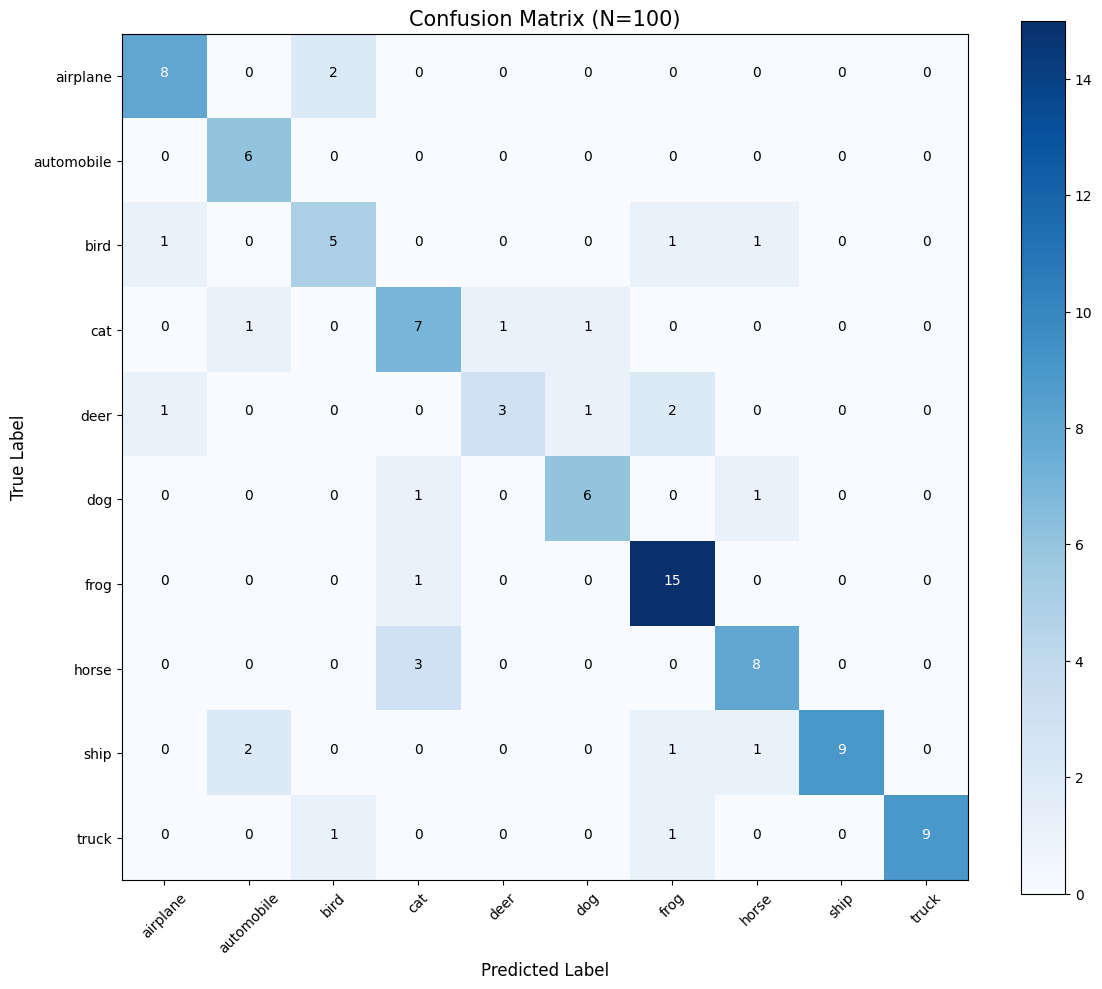

Class        | Precision  | Recall     | F1-Score  
--------------------------------------------------
airplane     | 0.8000     | 0.8000     | 0.8000
automobile   | 0.6667     | 1.0000     | 0.8000
bird         | 0.6250     | 0.6250     | 0.6250
cat          | 0.5833     | 0.7000     | 0.6364
deer         | 0.7500     | 0.4286     | 0.5455
dog          | 0.7500     | 0.7500     | 0.7500
frog         | 0.7500     | 0.9375     | 0.8333
horse        | 0.7273     | 0.7273     | 0.7273
ship         | 1.0000     | 0.6923     | 0.8182
truck        | 1.0000     | 0.8182     | 0.9000
--------------------------------------------------
Macro Avg    | 0.7652     | 0.7479     | 0.7436


In [9]:
# 1. Get Data
# We test on 100 images as in your previous test, increase N for better statistical significance
N_TEST = 100 
y_true, y_pred = get_predictions(N_TEST)

# 2. Compute Matrix
conf_matrix = calculate_confusion_matrix(y_true, y_pred)

# 3. Compute Metrics
precisions, recalls, f1s = calculate_metrics(conf_matrix)

# 4. Visualization
plt.figure(figsize=(12, 10))

# Plot Heatmap using Matplotlib (fallback if seaborn fails)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix (N={N_TEST})', fontsize=15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, cifar10_classes, rotation=45)
plt.yticks(tick_marks, cifar10_classes)

# Add text annotations to the heatmap
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# 5. Print Classification Report Table
print(f"{'Class':<12} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 50)

for i, class_name in enumerate(cifar10_classes):
    print(f"{class_name:<12} | {precisions[i]:.4f}     | {recalls[i]:.4f}     | {f1s[i]:.4f}")

print("-" * 50)
print(f"{'Macro Avg':<12} | {np.mean(precisions):.4f}     | {np.mean(recalls):.4f}     | {np.mean(f1s):.4f}")